In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torchvision import datasets, transforms
import helper
from torch import nn, optim
import torch.nn.functional as F

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [13]:
# TODO: Define your network architecture here
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        """Builds a feedforward network with arbitrary hidden layers
        
        Arguments
        ---------
        input_size: integer, size of input
        output_size: integer, size of output layer
        hidden_layers: list of integers, the sizes of the hidden layers
        drop_p: float between 0 and 1, dropout probability
        """
        super().__init__()
        
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout= nn.Dropout(p=drop_p)
        
    def forward(self, x):
        """Forward pass through the network, returns the output logits """
        
        # Forward throught each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [14]:
# TODO: Create the network, define the criterion and optimizer
model = Network(784, 10, [516, 256], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
def validation(model, testloader, criterion):    
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:       

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)

        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss, accuracy

In [16]:
# TODO: Train the network here
epochs = 2
steps = 0
running_loss = 0
print_every = 40

for e in range(epochs):
    model.train()
    for images, labels in trainloader:
        steps +=1
        
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            
            model.eval()
            
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                 "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                 "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                 "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            model.train()            
        

Epoch: 1/2..  Training Loss: 1.316..  Test Loss: 0.767..  Test Accuracy: 0.710
Epoch: 1/2..  Training Loss: 0.802..  Test Loss: 0.683..  Test Accuracy: 0.746
Epoch: 1/2..  Training Loss: 0.737..  Test Loss: 0.597..  Test Accuracy: 0.769
Epoch: 1/2..  Training Loss: 0.694..  Test Loss: 0.583..  Test Accuracy: 0.780
Epoch: 1/2..  Training Loss: 0.637..  Test Loss: 0.583..  Test Accuracy: 0.785
Epoch: 1/2..  Training Loss: 0.656..  Test Loss: 0.534..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.615..  Test Loss: 0.541..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.589..  Test Loss: 0.517..  Test Accuracy: 0.813
Epoch: 1/2..  Training Loss: 0.587..  Test Loss: 0.525..  Test Accuracy: 0.807
Epoch: 1/2..  Training Loss: 0.614..  Test Loss: 0.494..  Test Accuracy: 0.820
Epoch: 1/2..  Training Loss: 0.540..  Test Loss: 0.525..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.541..  Test Loss: 0.499..  Test Accuracy: 0.813
Epoch: 1/2..  Training Loss: 0.571..  Test Loss: 0.5

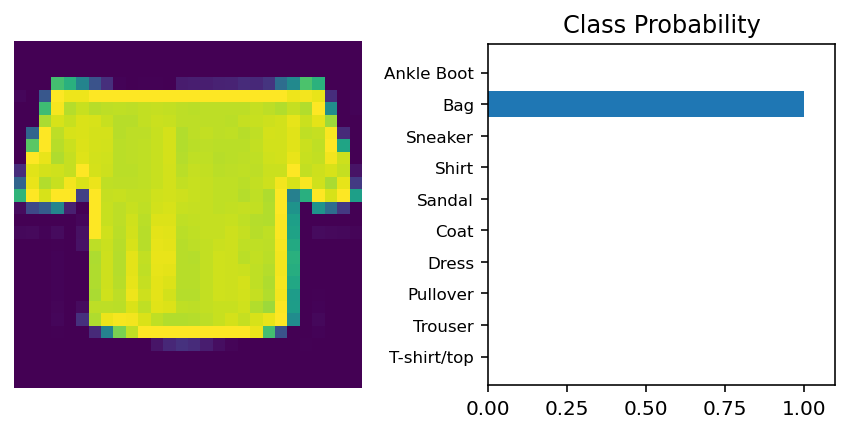

In [21]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Convert 2D image to 1D Vector
img = img.view(1, 784)

# Calculate the class probablities (softmax) for img
with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(image.view(1, 28, 28), ps, version='Fashion')